In [1]:
import sys
sys.path.append('/pscratch/sd/j/jianyao/forse_codes/') 
# sys.path.append('/global/cscratch1/sd/jianyao/ForSE/')
from forse.tools.img_tools import *
from forse.tools.mix_tools import *
from forse.tools.nn_tools import * 

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [34]:
import keras

In [1]:
import pymaster as nmt

In [15]:
import re

#### load files with patches
In the first file the first column has the total intensity small scales, while the second the large scale stokes Q maps (the total intensity small scales have been used to train the network, as explained in the paper, and represent our target distribution)

The second file has Stokes Q maps where small scales (below 80 amin) have been added as Gaussian realizaion of the extrapolation of the power spectra

here we rescale all the maps in the range [-1, 1]

and generate small scale features

# generate ss_QU from LS_QU

In [5]:
def prepare_small_scales(Ls_Q, Ls_U, Ss_gauss_Q, Ss_gauss_U):
    
    npatches = len(Ls_Q)
    ls_Q = np.zeros_like(Ls_Q); ls_U = np.zeros_like(Ls_Q); ss_gauss_Q = np.zeros_like(Ls_Q); ss_gauss_U = np.zeros_like(Ls_Q)
    ss_gauss_Q_ratio, ss_gauss_U_ratio= Ss_gauss_Q/Ls_Q, Ss_gauss_U/Ls_U # Remove large scales (80') from the gaussian maps, according the definition of ss in the paper
    for i in range(npatches):
        
        ls_Q[i], ls_U[i] = rescale_min_max(Ls_Q[i]), rescale_min_max(Ls_U[i])
        ss_gauss_Q[i], ss_gauss_U[i] = rescale_min_max(ss_gauss_Q_ratio[i]), rescale_min_max(ss_gauss_U_ratio[i])
        
    return ls_Q.reshape((npatches, 320, 320, 1)), ls_U.reshape((npatches, 320, 320, 1)), ss_gauss_Q.reshape((npatches, 320, 320, 1)), ss_gauss_U.reshape((npatches, 320, 320, 1)),ss_gauss_Q_ratio,ss_gauss_U_ratio

In [7]:
dir_data = '/global/cfs/cdirs/sobs/www/users/ForSE/NN_datautils/datasets/'

Thr, Ls_Q = np.load(dir_data+'GNILC_Thr12_Qlr80_20x20deg_Npix320_full_sky_adaptive.npy', allow_pickle=True)[:, 0:174]
Ls_U = np.load(dir_data+'GNILC_Thr12_Ulr80_20x20deg_Npix320_full_sky_adaptive.npy', allow_pickle=True)[1, 0:174]

Ss_gaussQ = np.load(dir_data+'GNILC_gaussian_ss_Q_20x20deg_Npix320_full_sky_adaptive.npy',  allow_pickle=True)
Ss_gaussU = np.load(dir_data+'GNILC_gaussian_ss_U_20x20deg_Npix320_full_sky_adaptive.npy',  allow_pickle=True)

Ls_scaled_Q, Ls_scaled_U, Ss_ratio_scaled_Q, Ss_ratio_scaled_U, Ss_ratio_Q, Ss_ratio_U = prepare_small_scales(Ls_Q, Ls_U, Ss_gaussQ, Ss_gaussU)

In [32]:
Ls_Q.shape

(174, 320, 320)

In [14]:
Ls_scaled_Q.shape

(174, 320, 320, 1)

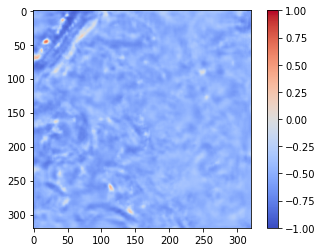

In [31]:
# dir_models = '/pscratch/sd/j/jianyao/forse_output/models_32/models/'
# dir_models = '/pscratch/sd/j/jianyao/forse_output/models_jupyter_my_DCGAN/models/'
# dir_models = '/pscratch/sd/j/jianyao/forse_output/Nico/models/'
# dir_models = '/pscratch/sd/j/jianyao/forse_output/modify_Adam_checkpoint/models/'
# dir_models = '/global/cfs/cdirs/sobs/www/users/ForSE/NN_datautils/weights/'
# dir_models = '/pscratch/sd/j/jianyao/forse_output/modify_Adam_b1_0p2/models/'
dir_models = '/pscratch/sd/j/jianyao/forse_output/U_modify_Adam_lr_5_1e-6/models/'
# generator_Q = tf.keras.models.load_model(dir_models+'generat_51500.h5') 
# NNout_Q = generator_Q.predict(Ls_scaled_Q)

# generator_U = tf.keras.models.load_model(dir_models+'forse_generator_U.h5')

generator_U = tf.keras.models.load_model(dir_models+'generat_40500.h5') # have not trained U!!!!!!!!
NNout_U = generator_U.predict(Ls_scaled_U)

plt.imshow(NNout_U[33,:,:,0], vmin=-1, vmax=1, cmap='coolwarm')
plt.colorbar()
# plt.title('NN 12 amin Q')

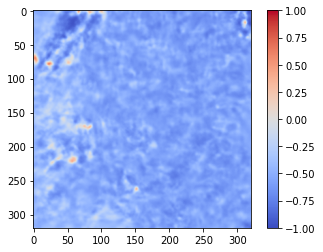

In [12]:
plt.imshow(NNout_U[33,:,:,0], vmin=-1, vmax=1, cmap='coolwarm')
plt.colorbar()

In [32]:
np.save('/pscratch/sd/j/jianyao/forse_output/NN_small_scales/NNout_U_lr_5e-6_71000.npy', NNout_U)

## MFs over different epoch

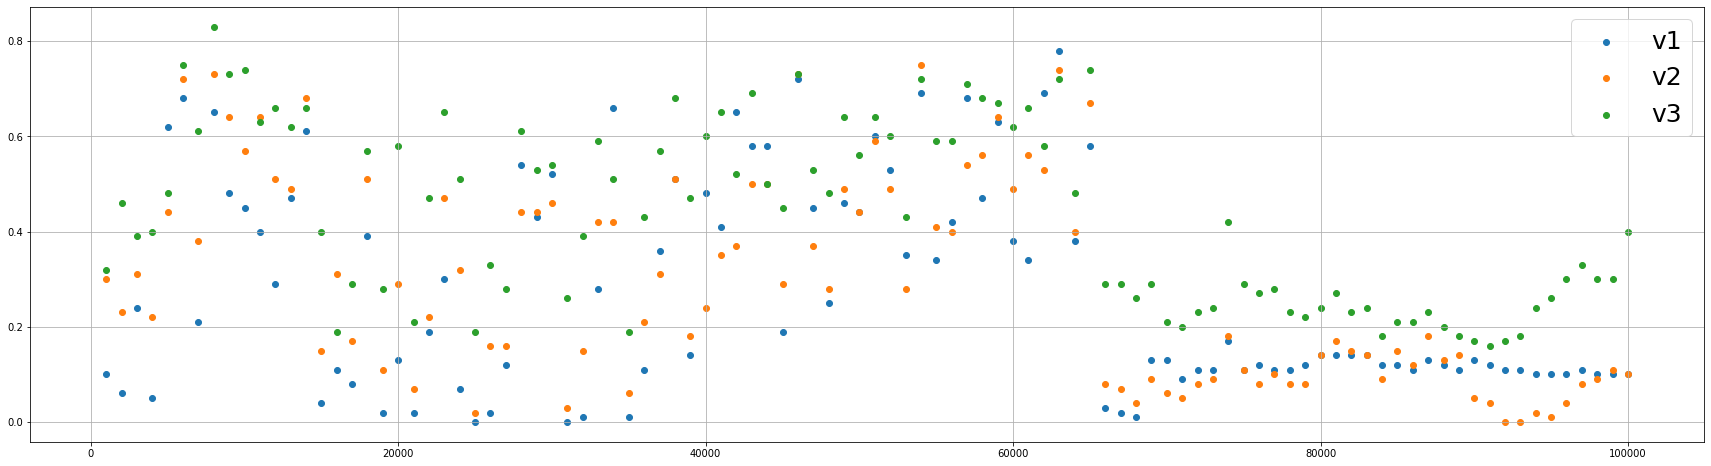

In [31]:
# data = np.loadtxt('MFs_modify_Adam_bs_32.txt')
data = np.loadtxt('MFs/MFs_my_dcgan.txt')
# data = np.loadtxt('MFs_tf_1.5_bs_16.txt')
epoch = np.arange(1000, 100001, 1000)

plt.figure(figsize = (30,8))
plt.scatter(epoch, data[:, 1],label = 'v1')
plt.scatter(epoch, data[:, 2], label = 'v2')
plt.scatter(epoch, data[:, 3], label = 'v3')
plt.legend(fontsize = 25)
plt.grid()

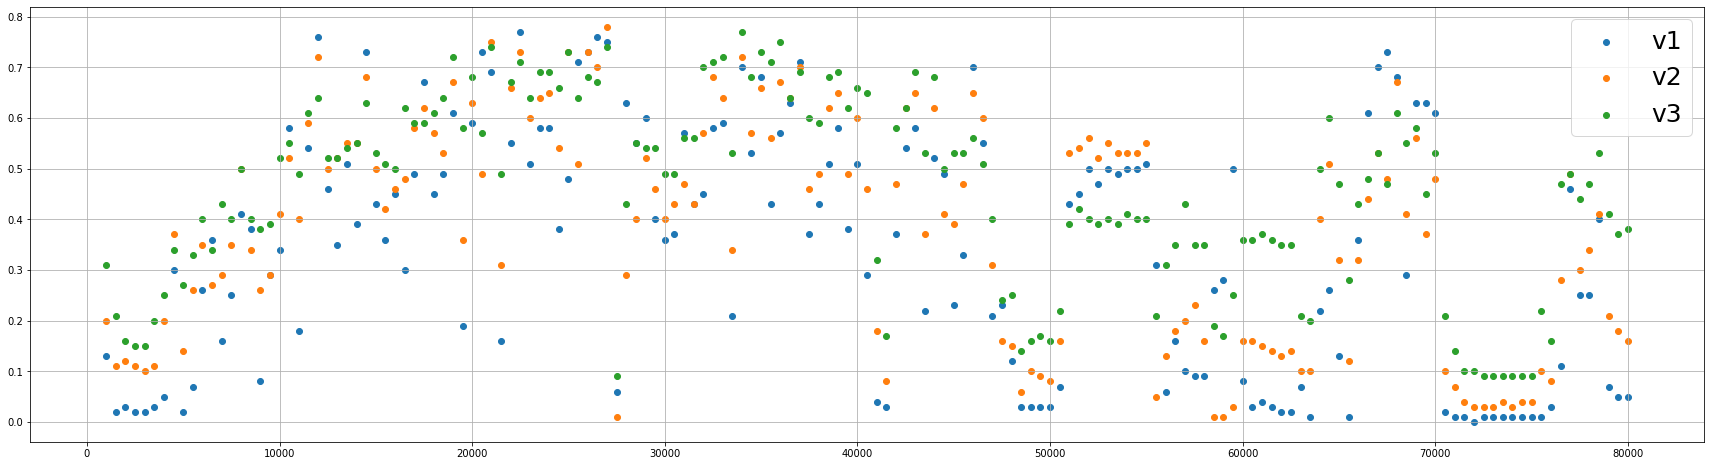

In [6]:
# data = np.loadtxt('MFs_modify_Adam_bs_32.txt')
data = np.loadtxt('MFs/MFs_b1_0p2_bs_32.txt')
# data = np.loadtxt('MFs_tf_1.5_bs_16.txt')
epoch = np.arange(1000, 80001, 500)

plt.figure(figsize = (30,8))
plt.scatter(epoch, data[:, 1],label = 'v1')
plt.scatter(epoch, data[:, 2], label = 'v2')
plt.scatter(epoch, data[:, 3], label = 'v3')
plt.legend(fontsize = 25)
plt.grid()

In [ ]:
data = np.loadtxt('MFs/MFs_b1_0p2_bs_32.txt')
# data = np.loadtxt('MFs_tf_1.5_bs_16.txt')
epoch = np.arange(1000, 100001, 500)

plt.figure(figsize = (30,8))
plt.scatter(epoch, data[:, 1],label = 'v1')
plt.scatter(epoch, data[:, 2], label = 'v2')
plt.scatter(epoch, data[:, 3], label = 'v3')
plt.legend(fontsize = 25)
plt.xticks(np.arange(1000, 100001, 5000))
plt.grid(b=True)

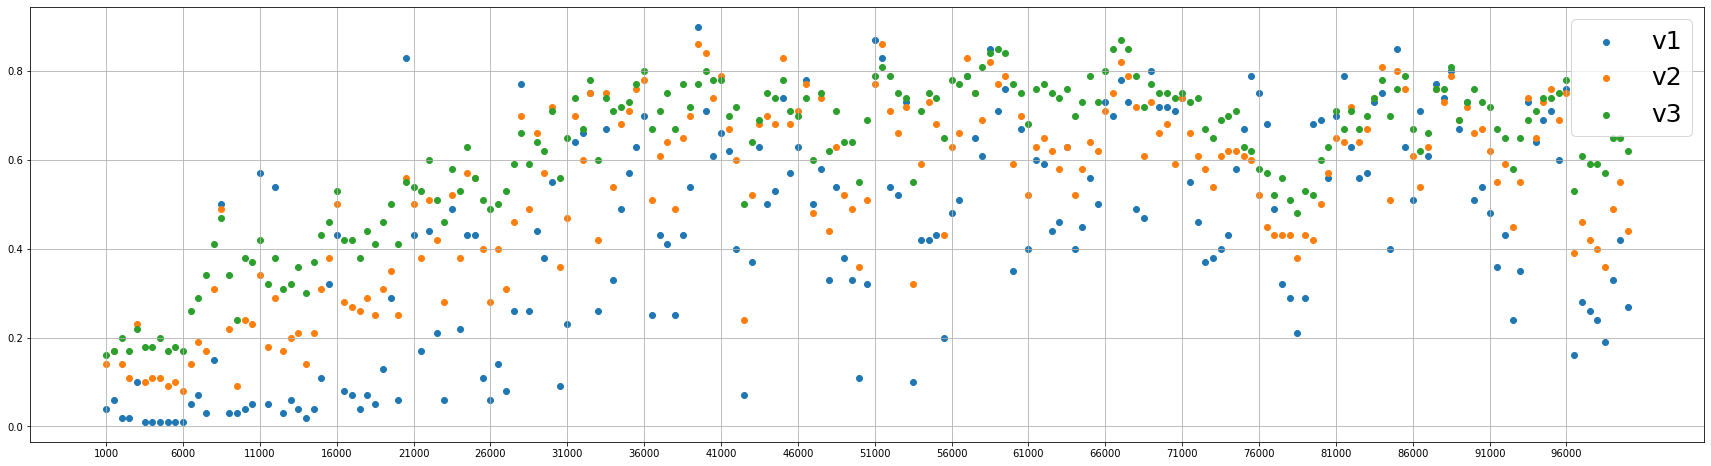

In [26]:
# data = np.loadtxt('MFs_modify_Adam_bs_32.txt')
data = np.loadtxt('MFs/MFs_lr_5_1e-6.txt')
# data = np.loadtxt('MFs_tf_1.5_bs_16.txt')
epoch = np.arange(1000, 100001, 500)

plt.figure(figsize = (30,8))
plt.scatter(epoch, data[:, 1],label = 'v1')
plt.scatter(epoch, data[:, 2], label = 'v2')
plt.scatter(epoch, data[:, 3], label = 'v3')
plt.legend(fontsize = 25)
plt.xticks(np.arange(1000, 100001, 5000))
plt.grid(b=True)

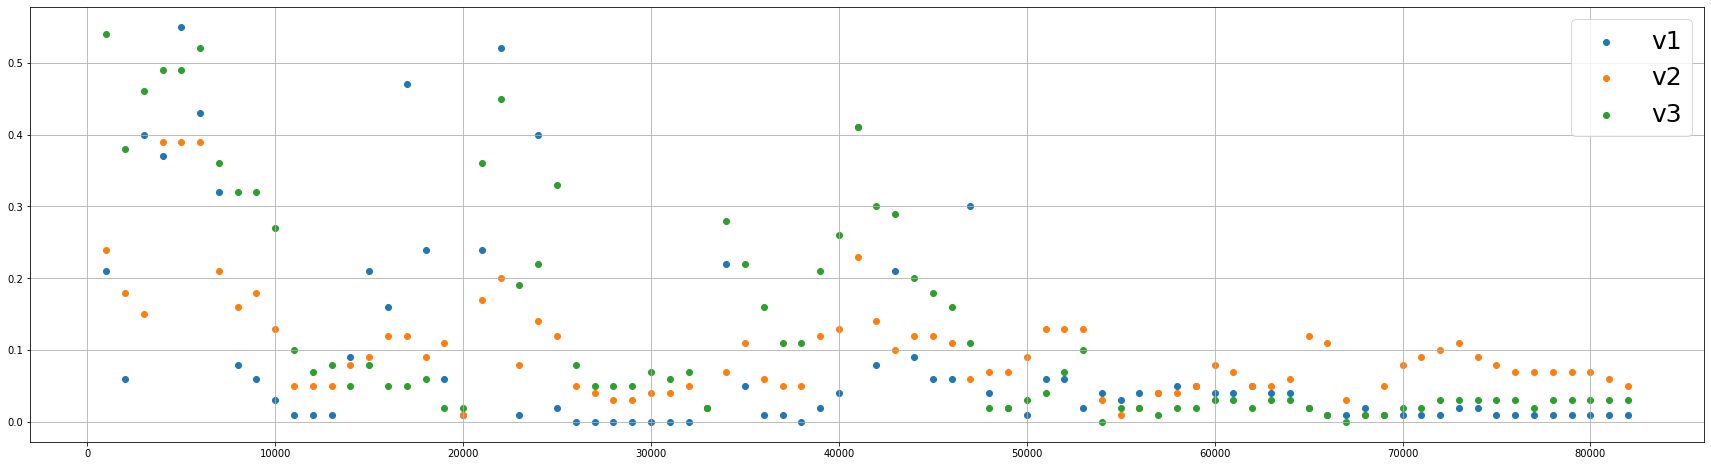

In [10]:
data = np.loadtxt('MFs/MFs_Nico_same.txt')
# data = np.loadtxt('MFs_tf_1.5_bs_16.txt')
epoch = np.arange(1000, 82001, 1000)

plt.figure(figsize = (30,8))
plt.scatter(epoch, data[:, 1],label = 'v1')
plt.scatter(epoch, data[:, 2], label = 'v2')
plt.scatter(epoch, data[:, 3], label = 'v3')
plt.legend(fontsize = 25)
# plt.xticks(np.arange(1000, 82001, 1000))
plt.grid(b=True)

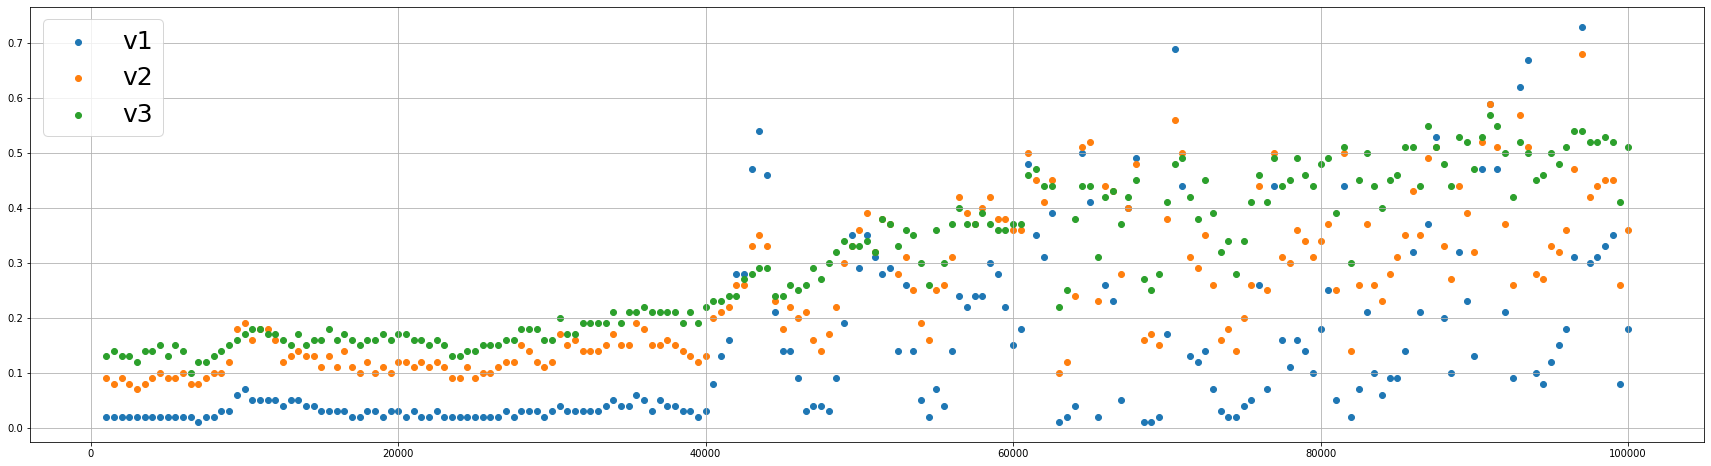

In [12]:
data = np.loadtxt('MFs/MFs_lr_1e-6.txt')
# data = np.loadtxt('MFs_tf_1.5_bs_16.txt')
epoch = np.arange(1000, 100001, 500)

plt.figure(figsize = (30,8))
plt.scatter(epoch, data[:, 1],label = 'v1')
plt.scatter(epoch, data[:, 2], label = 'v2')
plt.scatter(epoch, data[:, 3], label = 'v3')
plt.legend(fontsize = 25)
# plt.xticks(np.arange(1000, 82001, 1000))
plt.grid(b=True)

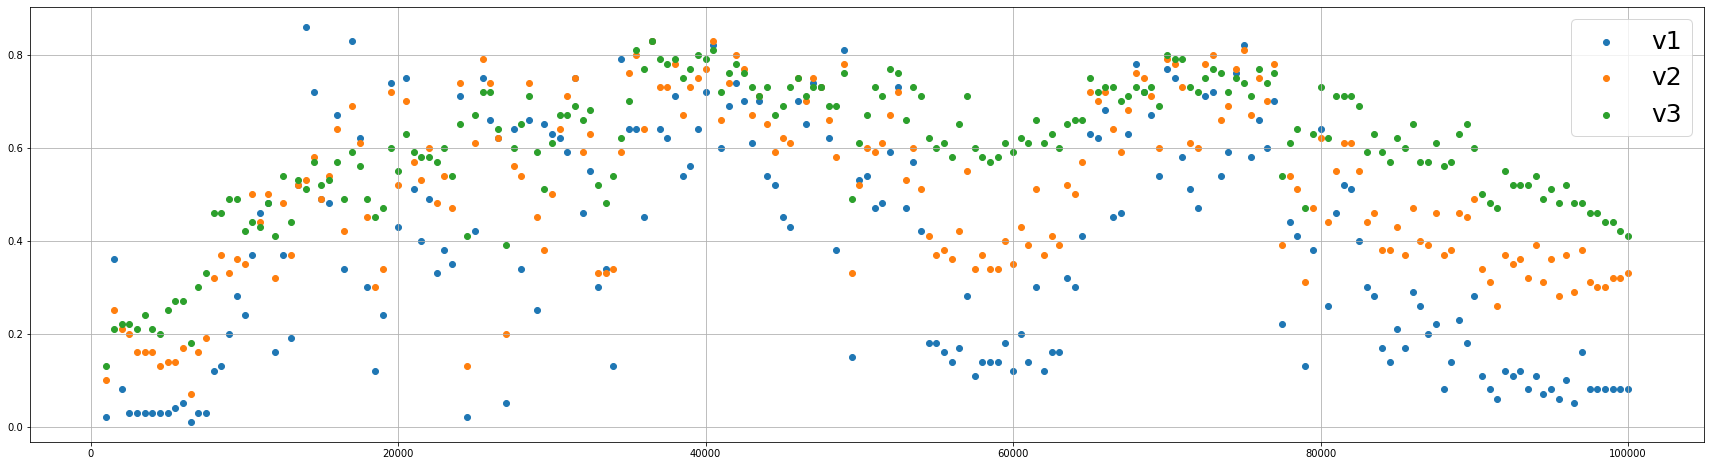

In [30]:
data = np.loadtxt('MFs/U_MFs_lr_5e-6.txt')
# data = np.loadtxt('MFs_tf_1.5_bs_16.txt')
epoch = np.arange(1000, 100001, 500)

plt.figure(figsize = (30,8))
plt.scatter(epoch, data[:, 1],label = 'v1')
plt.scatter(epoch, data[:, 2], label = 'v2')
plt.scatter(epoch, data[:, 3], label = 'v3')
plt.legend(fontsize = 25)
# plt.xticks(np.arange(1000, 82001, 1000))
plt.grid(b=True)

# comparision between Mine and Nico's generated maps

In [33]:
NN_Nico_Q = np.load('/pscratch/sd/j/jianyao/forse_output/NN_small_scales/NNout_Q_bs_16_Nico.npy')
NN_Yao_Q = np.load('/pscratch/sd/j/jianyao/forse_output/NN_small_scales/NNout_Q_lr_5e-6_51500.npy')

NN_Nico_U = np.load('/pscratch/sd/j/jianyao/forse_output/NN_small_scales/NNout_U_bs_16_Nico.npy')
NN_Yao_U = np.load('/pscratch/sd/j/jianyao/forse_output/NN_small_scales/NNout_U_lr_5e-6_71000.npy')

In [15]:
# fig, axes = plt.subplots(10,2, figsize = (8, 40))
# for i in range(10):
#     axes[i][0].imshow(NN_Nico[33+i*10], cmap='coolwarm')
#     axes[i][1].imshow(NNout_Q[33+i*10], cmap='coolwarm')

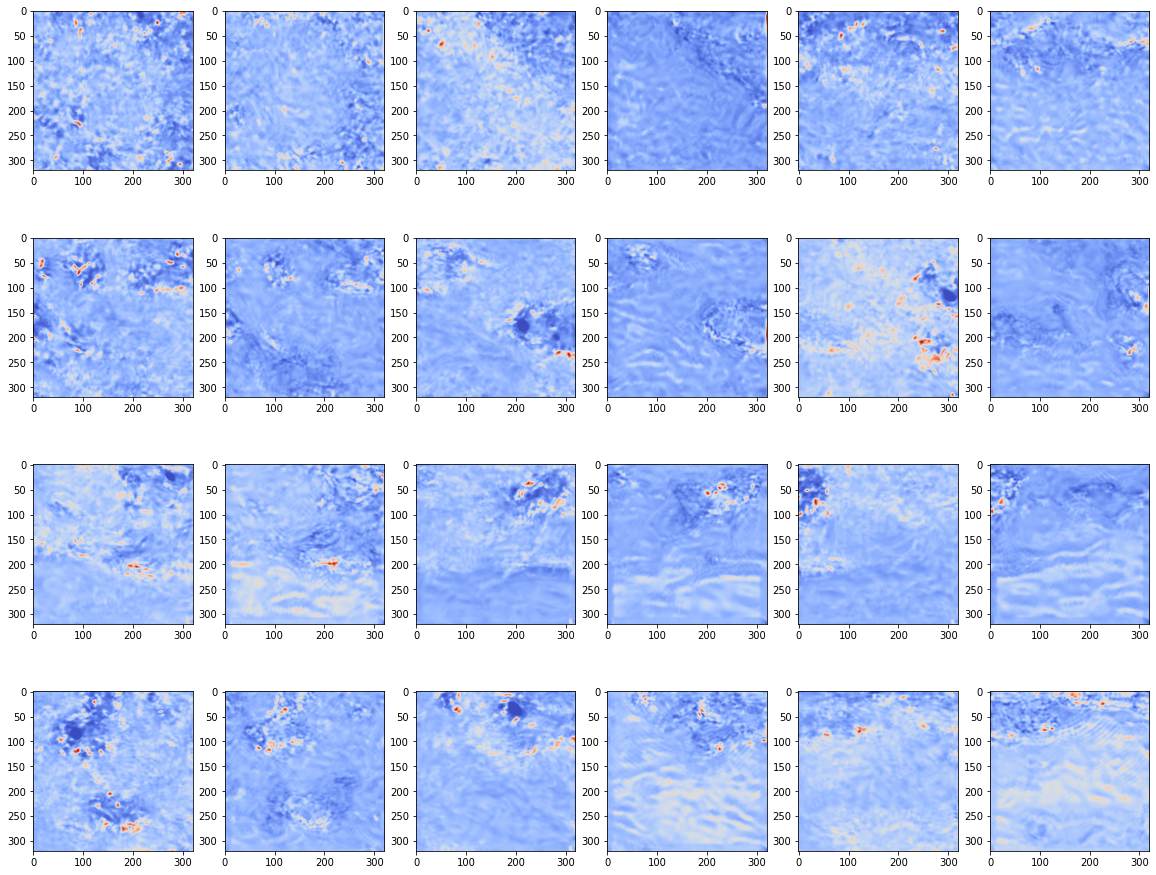

In [18]:
fig, axes = plt.subplots(4,6, figsize = (20, 16))
for i in range(4):
    axes[i][0].imshow(NN_Nico_Q[33+i*10], cmap='coolwarm')
    axes[i][1].imshow(NN_Yao_Q [33+i*10], cmap='coolwarm')
    axes[i][2].imshow(NN_Nico_Q[34+i*10], cmap='coolwarm')
    axes[i][3].imshow(NN_Yao_Q [34+i*10], cmap='coolwarm')
    axes[i][4].imshow(NN_Nico_Q[35+i*10], cmap='coolwarm')
    axes[i][5].imshow(NN_Yao_Q [35+i*10], cmap='coolwarm')

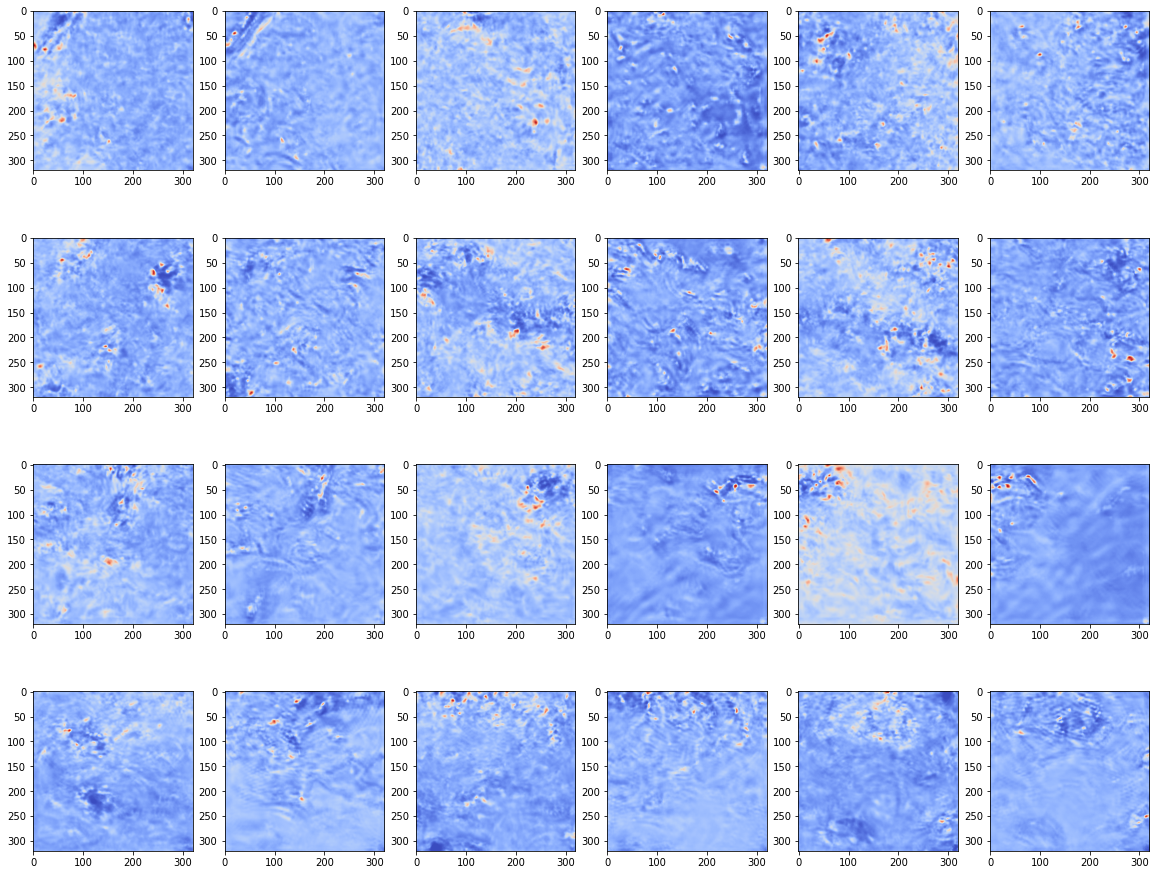

In [34]:
fig, axes = plt.subplots(4,6, figsize = (20, 16))
for i in range(4):
    axes[i][0].imshow(NN_Nico_U[33+i*10], cmap='coolwarm')
    axes[i][1].imshow(NN_Yao_U[33+i*10], cmap='coolwarm')
    axes[i][2].imshow(NN_Nico_U[34+i*10], cmap='coolwarm')
    axes[i][3].imshow(NN_Yao_U[34+i*10], cmap='coolwarm')
    axes[i][4].imshow(NN_Nico_U[35+i*10], cmap='coolwarm')
    axes[i][5].imshow(NN_Yao_U[35+i*10], cmap='coolwarm')

In [7]:
NN_Yao.shape

(174, 320, 320, 1)

#### Plot generated small scales 
Figure 6 in ForSE paper


NameError: name 'NNout_Q' is not defined

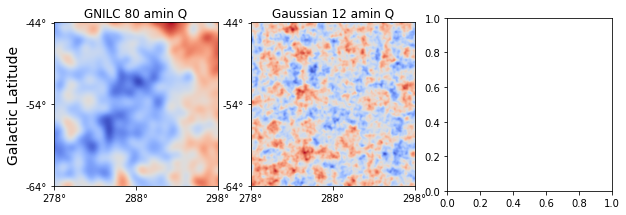

In [20]:
expl = 33

cmap = 'coolwarm'
plt.figure(figsize=(10, 7))
plt.subplot(231)
plt.imshow(Ls_scaled_Q[expl,:, :,0], vmin=-1, vmax=1, cmap='coolwarm')
plt.title('GNILC 80 amin Q')
plt.yticks((0, 160, 320), ('-44°', '-54°', '-64°') )
plt.xticks((0, 160, 320), ('278°', '288°', '298°') )
plt.ylabel('Galactic Latitude', fontsize=14)

plt.subplot(232)
plt.imshow(Ss_ratio_scaled_Q[expl,:,:,0], vmin=-1, vmax=1, cmap='coolwarm')
plt.title('Gaussian 12 amin Q')
#plt.xlabel('Galactic Longitude', fontsize=14)
plt.yticks((0, 160, 320), ('-44°', '-54°', '-64°') )
plt.xticks((0, 160, 320), ('278°', '288°', '298°') )

plt.subplot(233)
plt.imshow(NNout_Q[expl,:,:,0], vmin=-1, vmax=1, cmap='coolwarm')
plt.title('NN 12 amin Q')
plt.yticks((0, 160, 320), ('-44°', '-54°', '-64°') )
plt.xticks((0, 160, 320), ('278°', '288°', '298°') )

plt.subplot(234)
plt.imshow(Ls_scaled_U[expl,:, :,0], vmin=-1, vmax=1, cmap='coolwarm')
plt.title('GNILC 80 amin U')
plt.xlabel('Galactic Longitude', fontsize=14)
plt.yticks((0, 160, 320), ('-44°', '-54°', '-64°') )
plt.xticks((0, 160, 320), ('278°', '288°', '298°') )
plt.ylabel('Galactic Latitude', fontsize=14)


plt.subplot(235)
plt.imshow(Ss_ratio_scaled_U[expl,:,:,0], vmin=-1, vmax=1, cmap='coolwarm')
plt.title('Gaussian 12 amin U')
plt.xlabel('Galactic Longitude', fontsize=14)
plt.yticks((0, 160, 320), ('-44°', '-54°', '-64°') )
plt.xticks((0, 160, 320), ('278°', '288°', '298°') )

plt.subplot(236)
# plt.imshow(NNout_U[expl,:,:,0], vmin=-1, vmax=1, cmap='coolwarm')
plt.title('NN 12 amin U')
plt.xlabel('Galactic Longitude', fontsize=14)
plt.yticks((0, 160, 320), ('-44°', '-54°', '-64°') )
plt.xticks((0, 160, 320), ('278°', '288°', '298°') )


#### compute and plot minkowski functionals 
for both Q and U patches.
Figure 7 in ForSE paper


In [29]:
rhos_gss, f_gss, u_gss, chi_gss = [], [], [], []    
rhos_nn, f_nn, u_nn, chi_nn = [], [], [], []  
rhos_t, f_t, u_t, chi_t = [], [], [], []
npatches = 174
for i in range(0,npatches):
    rhos_Y, f_Y, u_Y, chi_Y = get_functionals(Ss_ratio_scaled_Q[i,:,:,0])
    mNN = rescale_min_max(NNout_Q[i,:,:,0], return_min_max=False)
    rhos_NN, f_NN, u_NN, chi_NN= get_functionals(mNN)
    mT = rescale_min_max(Thr[i], return_min_max=False)
    rhos_T, f_T, u_T, chi_T= get_functionals(mT)
    f_t.append(f_T);  u_t.append(u_T); chi_t.append(chi_T)
    f_gss.append(f_Y); f_nn.append(f_NN); 
    u_gss.append(u_Y); u_nn.append(u_NN);
    chi_gss.append(chi_Y); chi_nn.append(chi_NN); 

f_t = np.array(f_t); u_t = np.array(u_t); chi_t = np.array(chi_t)
f_gss = np.array(f_gss); f_nn = np.array(f_nn); 
u_gss = np.array(u_gss); u_nn = np.array(u_nn); 
chi_gss = np.array(chi_gss); chi_nn = np.array(chi_nn); 

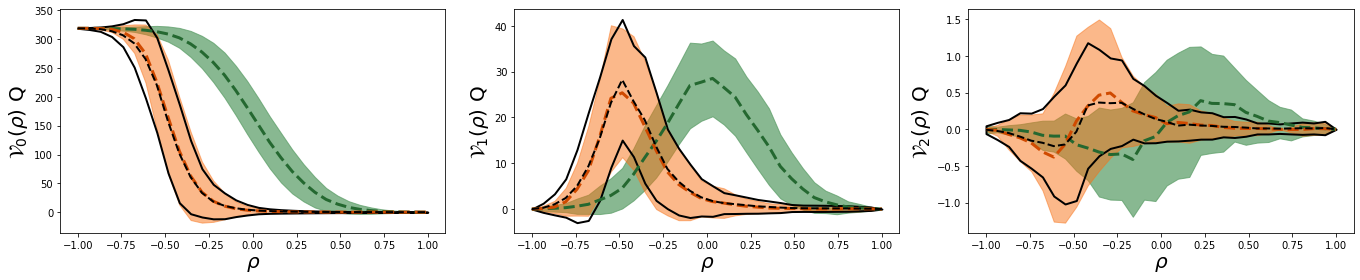

In [30]:
plt.figure(figsize=(19, 4))

plt.subplot(131)
plt.fill_between(rhos_Y, 
                     np.mean(f_gss, axis=0)-np.std(f_gss, axis=0), 
                     np.mean(f_gss, axis=0)+np.std(f_gss, axis=0), 
                     lw=1, label='gauss 12a', alpha=0.7, color='#569A62')
plt.plot(rhos_Y, np.mean(f_gss, axis=0), lw=3, ls='--', color='#246830')
plt.fill_between(rhos_Y, 
                     np.mean(f_nn, axis=0)-np.std(f_nn, axis=0), 
                     np.mean(f_nn, axis=0)+np.std(f_nn, axis=0), 
                     lw=1, label='NN 12a', alpha=0.5, color='#F87217')
plt.plot(rhos_Y, np.mean(f_nn, axis=0), lw=3, ls='--', color='#D04A00')
plt.fill_between(rhos_Y, 
                     np.mean(f_t, axis=0)-np.std(f_t, axis=0), 
                     np.mean(f_t, axis=0)+np.std(f_t, axis=0), 
                     lw=2, label='GNILC T 12a', edgecolor=(0,0,0,1), facecolor=(1,1,1,0))
plt.plot(rhos_Y, np.mean(f_t, axis=0), lw=2, ls='--', color='black')
plt.xlabel(r'$\rho$', fontsize=20)
plt.ylabel(r'$\mathcal{V}_0(\rho$) Q', fontsize=20)

plt.subplot(132)
plt.fill_between(rhos_Y, 
                     np.mean(u_gss, axis=0)-np.std(u_gss, axis=0), 
                     np.mean(u_gss, axis=0)+np.std(u_gss, axis=0), 
                     lw=1, label='gauss 12a', alpha=0.7, color='#569A62')
plt.plot(rhos_Y, np.mean(u_gss, axis=0), lw=3, ls='--', color='#246830')
plt.fill_between(rhos_Y, 
                     np.mean(u_nn, axis=0)-np.std(u_nn, axis=0), 
                     np.mean(u_nn, axis=0)+np.std(u_nn, axis=0), 
                     lw=1, label='NN 12a', alpha=0.5, color='#F87217')
plt.plot(rhos_Y, np.mean(u_nn, axis=0), lw=3, ls='--', color='#D04A00')
plt.fill_between(rhos_Y, 
                     np.mean(u_t, axis=0)-np.std(u_t, axis=0), 
                     np.mean(u_t, axis=0)+np.std(u_t, axis=0), 
                     lw=2, label='GNILC T 12a', edgecolor=(0,0,0,1), facecolor=(1,1,1,0))
plt.plot(rhos_Y, np.mean(u_t, axis=0), lw=2, ls='--', color='black')
plt.xlabel(r'$\rho$', fontsize=20)
plt.ylabel(r'$\mathcal{V}_1(\rho$) Q', fontsize=20)

plt.subplot(133)
plt.fill_between(rhos_Y, 
                     np.mean(chi_gss, axis=0)-np.std(chi_gss, axis=0), 
                     np.mean(chi_gss, axis=0)+np.std(chi_gss, axis=0), 
                     lw=1, label='gauss 12a', alpha=0.7, color='#569A62')
plt.plot(rhos_Y, np.mean(chi_gss, axis=0), lw=3, ls='--', color='#246830')

plt.fill_between(rhos_Y, 
                     np.mean(chi_nn, axis=0)-np.std(chi_nn, axis=0), 
                     np.mean(chi_nn, axis=0)+np.std(chi_nn, axis=0), 
                     lw=1, label='NN 12a', alpha=0.5, color='#F87217')
plt.plot(rhos_Y, np.mean(chi_nn, axis=0), lw=3, ls='--', color='#D04A00')
plt.fill_between(rhos_Y, 
                     np.mean(chi_t, axis=0)-np.std(chi_t, axis=0), 
                     np.mean(chi_t, axis=0)+np.std(chi_t, axis=0), 
                     lw=2, label='GNILC T 12a', edgecolor=(0,0,0,1), facecolor=(1,1,1,0))
plt.plot(rhos_Y, np.mean(chi_t, axis=0), lw=2, ls='--', color='black')
plt.xlabel(r'$\rho$', fontsize=20)
plt.ylabel(r'$\mathcal{V}_2(\rho$) Q', fontsize=20)
plt.tight_layout()

In [31]:
m1_nnq = compute_intersection(rhos_Y, 
                     [np.mean(f_t, axis=0)-np.std(f_t, axis=0), np.mean(f_t, axis=0)+np.std(f_t, axis=0)], 
                     [np.mean(f_nn, axis=0)-np.std(f_nn, axis=0),np.mean(f_nn, axis=0)+np.std(f_nn, axis=0)], 
                     npt=100000)
m2_nnq = compute_intersection(rhos_Y, 
                     [np.mean(u_t, axis=0)-np.std(u_t, axis=0), np.mean(u_t, axis=0)+np.std(u_t, axis=0)], 
                     [np.mean(u_nn, axis=0)-np.std(u_nn, axis=0),np.mean(u_nn, axis=0)+np.std(u_nn, axis=0)], 
                     npt=100000)
m3_nnq = compute_intersection(rhos_Y, 
                     [np.mean(chi_t, axis=0)-np.std(chi_t, axis=0), np.mean(chi_t, axis=0)+np.std(chi_t, axis=0)], 
                     [np.mean(chi_nn, axis=0)-np.std(chi_nn, axis=0),np.mean(chi_nn, axis=0)+np.std(chi_nn, axis=0)], 
                     npt=100000)

print(m1_nnq, m2_nnq, m3_nnq)

0.8319740500463392 0.862711296269693 0.8112402362354735


In [35]:
rhos_gss, f_gss, u_gss, chi_gss = [], [], [], []    
rhos_nn, f_nn, u_nn, chi_nn = [], [], [], []  
rhos_t, f_t, u_t, chi_t = [], [], [], []

npatches = 174
for i in range(0,npatches):
    rhos_Y, f_Y, u_Y, chi_Y = get_functionals(Ss_ratio_scaled_U[i,:,:,0])
    mNN = rescale_min_max(NNout_U[i,:,:,0], return_min_max=False)
    rhos_NN, f_NN, u_NN, chi_NN= get_functionals(mNN)
    mT = rescale_min_max(Thr[i], return_min_max=False)
    rhos_T, f_T, u_T, chi_T= get_functionals(mT)
    f_t.append(f_T);  u_t.append(u_T); chi_t.append(chi_T)
    f_gss.append(f_Y)
    f_nn.append(f_NN)
    u_gss.append(u_Y)
    u_nn.append(u_NN)
    chi_gss.append(chi_Y)
    chi_nn.append(chi_NN)

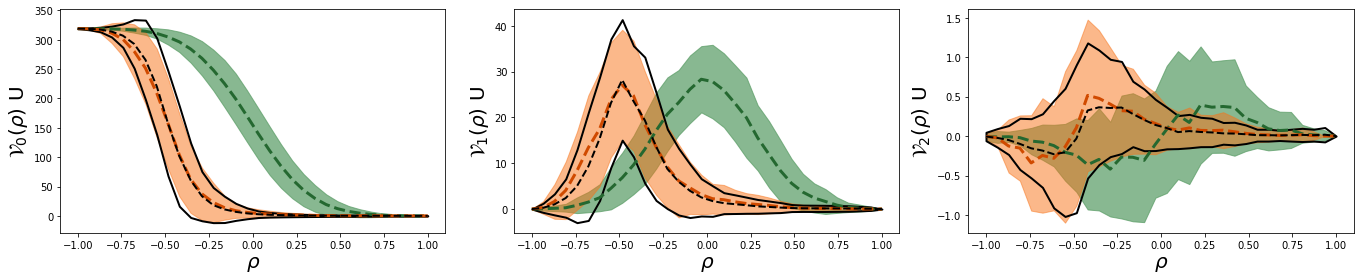

In [36]:
f_gss = np.array(f_gss)
f_nn = np.array(f_nn)
f_t = np.array(f_t)
u_gss = np.array(u_gss)
u_nn = np.array(u_nn)
u_t = np.array(u_t)
chi_gss = np.array(chi_gss)
chi_nn = np.array(chi_nn)
chi_t = np.array(chi_t)
plt.figure(figsize=(19, 4))

plt.subplot(131)
plt.fill_between(rhos_Y, 
                     np.mean(f_gss, axis=0)-np.std(f_gss, axis=0), 
                     np.mean(f_gss, axis=0)+np.std(f_gss, axis=0), 
                     lw=1, label='gauss 12a', alpha=0.7, color='#569A62')
plt.plot(rhos_Y, np.mean(f_gss, axis=0), lw=3, ls='--', color='#246830')
plt.fill_between(rhos_Y, 
                     np.mean(f_nn, axis=0)-np.std(f_nn, axis=0), 
                     np.mean(f_nn, axis=0)+np.std(f_nn, axis=0), 
                     lw=1, label='NN 12a', alpha=0.5, color='#F87217')
plt.plot(rhos_Y, np.mean(f_nn, axis=0), lw=3, ls='--', color='#D04A00')
plt.fill_between(rhos_Y, 
                     np.mean(f_t, axis=0)-np.std(f_t, axis=0), 
                     np.mean(f_t, axis=0)+np.std(f_t, axis=0), 
                     lw=2, label='GNILC T 12a', edgecolor=(0,0,0,1), facecolor=(1,1,1,0))
plt.plot(rhos_Y, np.mean(f_t, axis=0), lw=2, ls='--', color='black')


plt.xlabel(r'$\rho$', fontsize=20)
plt.ylabel(r'$\mathcal{V}_0(\rho$) U', fontsize=20)

plt.subplot(132)
plt.fill_between(rhos_Y, 
                     np.mean(u_gss, axis=0)-np.std(u_gss, axis=0), 
                     np.mean(u_gss, axis=0)+np.std(u_gss, axis=0), 
                     lw=1, label='gauss 12a', alpha=0.7, color='#569A62')
plt.plot(rhos_Y, np.mean(u_gss, axis=0), lw=3, ls='--', color='#246830')
plt.fill_between(rhos_Y, 
                     np.mean(u_nn, axis=0)-np.std(u_nn, axis=0), 
                     np.mean(u_nn, axis=0)+np.std(u_nn, axis=0), 
                     lw=1, label='NN 12a', alpha=0.5, color='#F87217')
plt.plot(rhos_Y, np.mean(u_nn, axis=0), lw=3, ls='--', color='#D04A00')
plt.fill_between(rhos_Y, 
                     np.mean(u_t, axis=0)-np.std(u_t, axis=0), 
                     np.mean(u_t, axis=0)+np.std(u_t, axis=0), 
                     lw=2, label='GNILC T 12a', edgecolor=(0,0,0,1), facecolor=(1,1,1,0))
plt.plot(rhos_Y, np.mean(u_t, axis=0), lw=2, ls='--', color='black')
plt.xlabel(r'$\rho$', fontsize=20)
plt.ylabel(r'$\mathcal{V}_1(\rho$) U', fontsize=20)

plt.subplot(133)
plt.fill_between(rhos_Y, 
                     np.mean(chi_gss, axis=0)-np.std(chi_gss, axis=0), 
                     np.mean(chi_gss, axis=0)+np.std(chi_gss, axis=0), 
                     lw=1, label='gauss 12a', alpha=0.7, color='#569A62')
plt.plot(rhos_Y, np.mean(chi_gss, axis=0), lw=3, ls='--', color='#246830')

plt.fill_between(rhos_Y, 
                     np.mean(chi_nn, axis=0)-np.std(chi_nn, axis=0), 
                     np.mean(chi_nn, axis=0)+np.std(chi_nn, axis=0), 
                     lw=1, label='NN 12a', alpha=0.5, color='#F87217')
plt.plot(rhos_Y, np.mean(chi_nn, axis=0), lw=3, ls='--', color='#D04A00')
plt.fill_between(rhos_Y, 
                     np.mean(chi_t, axis=0)-np.std(chi_t, axis=0), 
                     np.mean(chi_t, axis=0)+np.std(chi_t, axis=0), 
                     lw=2, label='GNILC T 12a', edgecolor=(0,0,0,1), facecolor=(1,1,1,0))
plt.plot(rhos_Y, np.mean(chi_t, axis=0), lw=2, ls='--', color='black')
plt.xlabel(r'$\rho$', fontsize=20)
plt.ylabel(r'$\mathcal{V}_2(\rho$) U', fontsize=20)
plt.tight_layout()

In [37]:
m1_nnq = compute_intersection(rhos_Y, 
                     [np.mean(f_t, axis=0)-np.std(f_t, axis=0), np.mean(f_t, axis=0)+np.std(f_t, axis=0)], 
                     [np.mean(f_nn, axis=0)-np.std(f_nn, axis=0),np.mean(f_nn, axis=0)+np.std(f_nn, axis=0)], 
                     npt=100000)
m2_nnq = compute_intersection(rhos_Y, 
                     [np.mean(u_t, axis=0)-np.std(u_t, axis=0), np.mean(u_t, axis=0)+np.std(u_t, axis=0)], 
                     [np.mean(u_nn, axis=0)-np.std(u_nn, axis=0),np.mean(u_nn, axis=0)+np.std(u_nn, axis=0)], 
                     npt=100000)
m3_nnq = compute_intersection(rhos_Y, 
                     [np.mean(chi_t, axis=0)-np.std(chi_t, axis=0), np.mean(chi_t, axis=0)+np.std(chi_t, axis=0)], 
                     [np.mean(chi_nn, axis=0)-np.std(chi_nn, axis=0),np.mean(chi_nn, axis=0)+np.std(chi_nn, axis=0)], 
                     npt=100000)

print(m1_nnq, m2_nnq, m3_nnq)

0.8173727635116343 0.824450677886863 0.813947704987921


### First normalization to phyiscal units
we normalize the generated small scales to physical units by using the information on mean and standard deviation taken from the Gaussian ones, for both Q and U

In [64]:
npatches = 174
NNout_normed_Q = np.copy(NNout_Q)
NNout_normed_U = np.copy(NNout_U)
for i in range(npatches):
    NNout_normed_Q[i] = NNout_normed_Q[i]/np.std(NNout_normed_Q[i])*np.std(Ss_ratio_Q[i])
    NNout_normed_Q[i] = NNout_normed_Q[i]-np.mean(NNout_normed_Q[i])+np.mean(Ss_ratio_Q[i])
    NNout_normed_U[i] = NNout_normed_U[i]/np.std(NNout_normed_U[i])*np.std(Ss_ratio_U[i])
    NNout_normed_U[i] = NNout_normed_U[i]-np.mean(NNout_normed_U[i])+np.mean(Ss_ratio_U[i])

go to muK_CMB units

In [65]:
NNmapQ = NNout_normed_Q[:,:,:,0]*Ls_Q*1e6
LSmapQ = Ls_Q*1e6
SSmapQ = Ss_gaussQ*1e6
NNmapU = NNout_normed_U[:,:,:,0]*Ls_U*1e6
LSmapU = Ls_U*1e6
SSmapU = Ss_gaussU*1e6

In [66]:
SSmapU.shape

(174, 320, 320)

In [51]:
Lx = np.radians(20.)
Ly = np.radians(20.)
Nx = 320
Ny = 320

mask = np.ones_like(LSmapQ[0]).flatten()
xarr = np.ones(Ny)[:, None] * np.arange(Nx)[None, :] * Lx/Nx
yarr = np.ones(Nx)[None, :] * np.arange(Ny)[:, None] * Ly/Ny
mask[np.where(xarr.flatten() < Lx / 100.)] = 0
mask[np.where(xarr.flatten() > 99 * Lx / 100.)] = 0
mask[np.where(yarr.flatten() < Ly / 100.)] = 0
mask[np.where(yarr.flatten() > 99 * Ly / 100.)] = 0
mask = mask.reshape([Ny, Nx])
mask = nmt.mask_apodization_flat(mask, Lx, Ly, aposize=2., apotype="C1")

### Refine normalization to physical units
here we use spectra of Q and U maps to refine the normalization to physical units. We match the amplitude of the spectra of the NN generate small scale maps with that of the gaussian small scales

In [67]:
l0_bins = np.arange(20, 1000, 40)
lf_bins = np.arange(20, 1000, 40)+39
b = nmt.NmtBinFlat(l0_bins, lf_bins)
ells_uncoupled = b.get_effective_ells()

In [68]:
f_SSQ = nmt.NmtFieldFlat(Lx, Ly, mask, [SSmapQ[0]/LSmapQ[0]])
w00 = nmt.NmtWorkspaceFlat()
w00.compute_coupling_matrix(f_SSQ, f_SSQ, b)

In [69]:
NNmapQ_corr = np.copy(NNmapQ)
NNmapU_corr = np.copy(NNmapU)
for N in range(0, 174):
    f_SSQ = nmt.NmtFieldFlat(Lx, Ly, mask, [SSmapQ[N]/LSmapQ[N]])
    cl_SS_coupledQ = nmt.compute_coupled_cell_flat(f_SSQ, f_SSQ, b)
    cl_SS_uncoupledQ = w00.decouple_cell(cl_SS_coupledQ)
    f_SSU = nmt.NmtFieldFlat(Lx, Ly, mask, [SSmapU[N]/LSmapU[N]])
    cl_SS_coupledU = nmt.compute_coupled_cell_flat(f_SSU, f_SSU, b)
    cl_SS_uncoupledU = w00.decouple_cell(cl_SS_coupledU)
    f_NNQ = nmt.NmtFieldFlat(Lx, Ly, mask, [NNmapQ[N]/LSmapQ[N]])
    cl_NN_coupledQ = nmt.compute_coupled_cell_flat(f_NNQ, f_NNQ, b)
    cl_NN_uncoupledQ = w00.decouple_cell(cl_NN_coupledQ)
    f_NNU = nmt.NmtFieldFlat(Lx, Ly, mask, [NNmapU[N]/LSmapU[N]])
    cl_NN_coupledU = nmt.compute_coupled_cell_flat(f_NNU, f_NNU, b)
    cl_NN_uncoupledU = w00.decouple_cell(cl_NN_coupledU)
    newQ = NNmapQ[N]/np.sqrt(np.mean(cl_NN_uncoupledQ[0][4:]/cl_SS_uncoupledQ[0][4:]))
    newU = NNmapU[N]/np.sqrt(np.mean(cl_NN_uncoupledU[0][4:]/cl_SS_uncoupledU[0][4:]))
    newQ = ((newQ/LSmapQ[N])-np.mean(newQ/LSmapQ[N])+np.mean(SSmapQ[N]/LSmapQ[N]))*LSmapQ[N]
    newU = ((newU/LSmapU[N])-np.mean(newU/LSmapU[N])+np.mean(SSmapU[N]/LSmapU[N]))*LSmapU[N]
    NNmapQ_corr[N] = newQ
    NNmapU_corr[N] = newU

#### plot final images
figure 8 in ForSE paper

In [70]:
N = 33
P_LS = np.sqrt(LSmapQ[N]**2.+LSmapU[N]**2)
P_SS = np.sqrt(SSmapQ[N]**2.+SSmapU[N]**2)
P_NN = np.sqrt(NNmapQ_corr[N]**2.+NNmapU_corr[N]**2)


cmap = 'coolwarm'
plt.figure(figsize=(12, 14))

plt.subplot(331)
plt.imshow(LSmapQ[N], cmap=cmap, vmin=-30, vmax=30)
plt.title('GNILC 80 amin Q')
plt.xticks((0, 160, 320), ('278°', '288°', '298°') )
plt.yticks((0, 160, 320), ('-44°', '-54°', '-64°') )
plt.ylabel('Galactic Latitude', fontsize=14)

plt.subplot(332)
plt.imshow(NNmapQ_corr[N], cmap=cmap, vmin=-30, vmax=30)
plt.title('GNILC+NN 12 amin Q')
plt.xticks((0, 160, 320), ('278°', '288°', '298°') )
plt.yticks((0, 160, 320), ('-44°', '-54°', '-64°') )

plt.subplot(333)
plt.imshow(SSmapQ[N], cmap=cmap, vmin=-30, vmax=30)
plt.title('GNILC+Gauss 12 amin Q')
plt.xticks((0, 160, 320), ('278°', '288°', '298°') )
plt.yticks((0, 160, 320), ('-44°', '-54°', '-64°') )

plt.subplot(334)
v = 60
plt.imshow(LSmapU[N], cmap=cmap, vmin=-60, vmax=60)
plt.title('GNILC 80 amin U')
plt.xticks((0, 160, 320), ('278°', '288°', '298°') )
plt.yticks((0, 160, 320), ('-44°', '-54°', '-64°') )
plt.ylabel('Galactic Latitude', fontsize=14)

plt.subplot(335)
plt.imshow(NNmapU_corr[N], cmap=cmap, vmin=-60, vmax=60)
plt.title('GNILC+NN 12 amin U')
plt.xticks((0, 160, 320), ('278°', '288°', '298°') )
plt.yticks((0, 160, 320), ('-44°', '-54°', '-64°') )

plt.subplot(336)
plt.imshow(SSmapU[N], cmap=cmap, vmin=-60, vmax=60)
plt.title('GNILC+Gauss 12 amin U')
plt.xticks((0, 160, 320), ('278°', '288°', '298°') )
plt.yticks((0, 160, 320), ('-44°', '-54°', '-64°') )

plt.subplot(337)
v = 60
plt.imshow(P_LS, cmap=cmap, vmin=0, vmax=60)
plt.title('GNILC 80 amin P')
plt.xticks((0, 160, 320), ('278°', '288°', '298°') )
plt.xlabel('Galactic Longitude', fontsize=14)
plt.yticks((0, 160, 320), ('-44°', '-54°', '-64°') )
plt.ylabel('Galactic Latitude', fontsize=14)

plt.subplot(338)
plt.imshow(P_NN, cmap=cmap, vmin=0, vmax=60)
plt.title('GNILC+NN 12 amin P')
plt.xticks((0, 160, 320), ('278°', '288°', '298°') )
plt.xlabel('Galactic Longitude', fontsize=14)
plt.yticks((0, 160, 320), ('-44°', '-54°', '-64°') )

plt.subplot(339)
plt.imshow(P_SS, cmap=cmap, vmin=0, vmax=60)
plt.title('GNILC+Gauss 12 amin P')
plt.xticks((0, 160, 320), ('278°', '288°', '298°') )
plt.xlabel('Galactic Longitude', fontsize=14)
plt.yticks((0, 160, 320), ('-44°', '-54°', '-64°') )

([<matplotlib.axis.YTick at 0x7f6d817af7c0>,
 [Text(0, 0, '-44°'), Text(0, 160, '-54°'), Text(0, 320, '-64°')])

#### compute polarization power spectra


In [71]:
N = 33

In [72]:
f_NN = nmt.NmtFieldFlat(Lx, Ly, mask, [NNmapQ_corr[N], NNmapU_corr[N]], purify_b=True)
w22 = nmt.NmtWorkspaceFlat()
w22.compute_coupling_matrix(f_NN, f_NN, b)
cl_NN_coupled = nmt.compute_coupled_cell_flat(f_NN, f_NN, b)
cl_NN_uncoupled = w22.decouple_cell(cl_NN_coupled)
f_LS = nmt.NmtFieldFlat(Lx, Ly, mask, [LSmapQ[N], LSmapU[N]], purify_b=True)
cl_LS_coupled = nmt.compute_coupled_cell_flat(f_LS, f_LS, b)
cl_LS_uncoupled = w22.decouple_cell(cl_LS_coupled)
f_SS = nmt.NmtFieldFlat(Lx, Ly, mask, [SSmapQ[N], SSmapU[N]], purify_b=True)
cl_SS_coupled = nmt.compute_coupled_cell_flat(f_SS, f_SS, b)
cl_SS_uncoupled = w22.decouple_cell(cl_SS_coupled)

In [73]:
plt.figure(figsize=(13, 4.5))
plt.subplot(121)
plt.loglog(ells_uncoupled, cl_LS_uncoupled[0],  '--', lw=2, color='Black', alpha=0.5, label = 'GNILC 80 amin')
plt.loglog(ells_uncoupled, cl_SS_uncoupled[0], '-', label='GNILC+Gauss 12 amin', lw=4, color='#569A62', alpha=0.7)
plt.loglog(ells_uncoupled, cl_NN_uncoupled[0], '-', label='GNILC+NN 12 amin', lw=4, color='#F87217', alpha=0.7)
plt.ylabel(r'$C_\ell$', fontsize=16)
plt.ylim(1e-6, 2e-1)
plt.xticks([40, 100, 400, 1000], [40, 100, 400, 1000])
plt.tick_params(axis='both', which='major', labelsize=18)
plt.title('EE', fontsize=18)
plt.xlabel(r'Multipole $\ell$', fontsize=18)
plt.ylabel(r'$C_\ell$ [$\mu K^2$]', fontsize=18)
plt.tight_layout()

plt.subplot(122)
plt.loglog(ells_uncoupled, cl_LS_uncoupled[3],  '--', lw=2, color='Black', alpha=0.5, label = 'GNILC 80 amin')
plt.loglog(ells_uncoupled, cl_SS_uncoupled[3], '-', label='GNILC+Gauss 12 amin', lw=4, color='#569A62', alpha=0.7)
plt.loglog(ells_uncoupled, cl_NN_uncoupled[3], '-', label='GNILC+NN 12 amin', lw=4, color='#F87217', alpha=0.7)
plt.ylabel(r'$C_\ell$', fontsize=16)
plt.ylim(1e-6, 2e-1)
plt.legend(fontsize=13)
plt.xticks([40, 100, 400, 1000], [40, 100, 400, 1000])
plt.tick_params(axis='both', which='major', labelsize=18)
plt.title('BB', fontsize=18)
plt.xlabel(r'Multipole $\ell$', fontsize=18)
plt.ylabel(r'$C_\ell$ [$\mu K^2$]', fontsize=18)
plt.tight_layout()